In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
import matplotlib.colors as mcolors
from matplotlib.transforms import Bbox
from matplotlib.colors import to_rgba
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import scvi
import scanpy as sc
import itertools
from sklearn.preprocessing import MinMaxScaler
import anndata as an
import scanpy.external as sce
from matplotlib.path import Path
import scipy
import scipy.sparse as sp
import gget
import time
import sklearn
import torch
from scipy.sparse import csr_matrix
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.manifold import MDS
from brokenaxes import brokenaxes
import sklearn.metrics as sm
from adjustText import adjust_text

from importlib import reload

# local imports
import utils as ut
import plotting as plt2

sc.settings.verbosity = 3 

# Load Data

In [2]:
# fpath = "/scratch/indikar_root/indikar1/shared_data/scanvi_model_minimal/imputed_adata/hvg13000.h5ad"
fpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/pipeline_outputs/scanvi_model_full/imputed_adata/hvg11000.h5ad"
adata = sc.read_h5ad(fpath)
adata.X = adata.layers['scanvi_counts'].copy()

# make counts out of 10000
scale_expression  = 1e4
adata.layers['scaled_scanvi'] = np.log1p(adata.layers['scanvi_counts'] * scale_expression)

# sc.tl.embedding_density(adata, basis='umap')

sc.logging.print_memory_usage()
print(adata)

Memory usage: current 21.21 GB, difference +21.21 GB
AnnData object with n_obs × n_vars = 145439 × 11000
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_label', '_scvi_batch', '_scvi_labels', 'batch'
    uns: 'neighbors', 'pca', 'umap'
    obsm: 'X_harmony', 'X_pca', 'X_scanorama', 'X_scanvi', 'X_scvi', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'scanvi_counts', 'scaled_scanvi'
    obsp: 'connectivities', 'distances'


# Load gene sets

In [3]:
reload(ut)
fpath = "../resources/PanglaoDB_Augmented_2021.txt"
features = ut.load_pathway(fpath)

[x for x in features.columns if 'hemato' in x.lower()]

# pathway = 'Hematopoietic Stem Cells'
pathway = 'Fibroblasts'
query_genes = list(features[features[pathway]].index)
print(len(query_genes))
query_genes[:10]

232


['RARRES2',
 'CELA1',
 'LUM',
 'PRRX1',
 'SCARA5',
 'COL1A1',
 'COL5A2',
 'COL5A1',
 'FNDC1',
 'COL12A1']

In [4]:
fpath = "../resources/scenic.tf_list.txt"
tf_list = [x.strip() for x in open(fpath)]
tf_list[:10]

['ZNF354C',
 'KLF12',
 'ZNF143',
 'ZIC2',
 'ZNF274',
 'SP2',
 'ZBTB7A',
 'BCL6B',
 'ZBTB49',
 'ZIC1']

# Filter dataset

In [5]:
mask = (adata.obs['dataset'] != 'pellin')
adata = adata[mask, :].copy()

mask = (adata.obs['dataset'] != 'tabula_sapiens')
adata = adata[mask, :].copy()

adata

AnnData object with n_obs × n_vars = 107947 × 11000
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_label', '_scvi_batch', '_scvi_labels', 'batch'
    uns: 'neighbors', 'pca', 'umap'
    obsm: 'X_harmony', 'X_pca', 'X_scanorama', 'X_scanvi', 'X_scvi', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'scanvi_counts', 'scaled_scanvi'
    obsp: 'connectivities', 'distances'

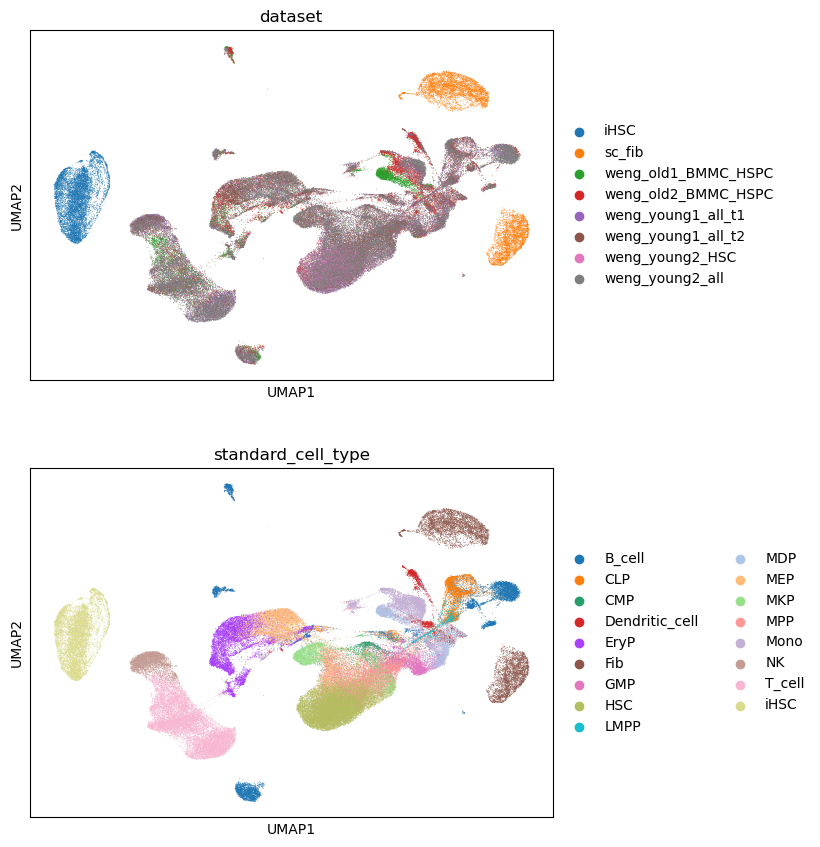

In [6]:
sc.pl.umap(
    adata,
    color=[
        'dataset',
        'standard_cell_type',
    ],
    ncols=1,
)

In [7]:
# break

# aggregate distances

In [8]:
aggdata = sc.get.aggregate(
    adata,
    by='standard_cell_type',
    func='mean',
    layer='scaled_scanvi'
)

aggdata.X = aggdata.layers['mean'].copy()

df = aggdata.to_df()
df = df.T
df.head()

,B_cell,CLP,CMP,Dendritic_cell,EryP,Fib,GMP,HSC,LMPP,MDP,MEP,MKP,MPP,Mono,NK,T_cell,iHSC
gene_name,,,,,,,,,,,,,,,,,
A2M,0.142066,0.134279,0.225081,0.138404,0.181637,0.179508,0.146095,0.272067,0.192740,0.112952,0.127397,0.232199,0.286161,0.111637,1.376621,1.028075,0.267645
A2ML1,0.034079,0.038107,0.058474,0.026994,0.038923,1.461061,0.043119,0.062106,0.035823,0.028450,0.052800,0.056572,0.062746,0.025026,0.018274,0.013843,0.982625
A4GALT,0.047645,0.032971,0.016963,0.075987,0.420508,0.013664,0.025551,0.009208,0.023688,0.047269,0.068602,0.018756,0.010031,0.077158,0.057567,0.040535,0.033216
AACS,0.156714,0.103656,0.199423,0.274431,0.131799,0.075285,0.205798,0.145128,0.127280,0.175725,0.153215,0.191003,0.154968,0.153176,0.302703,0.207426,0.111764
AADAC,0.018303,0.013395,0.012446,0.015009,0.019339,0.776738,0.011053,0.012274,0.012385,0.018289,0.015212,0.015473,0.011213,0.021059,0.020909,0.018374,0.993852


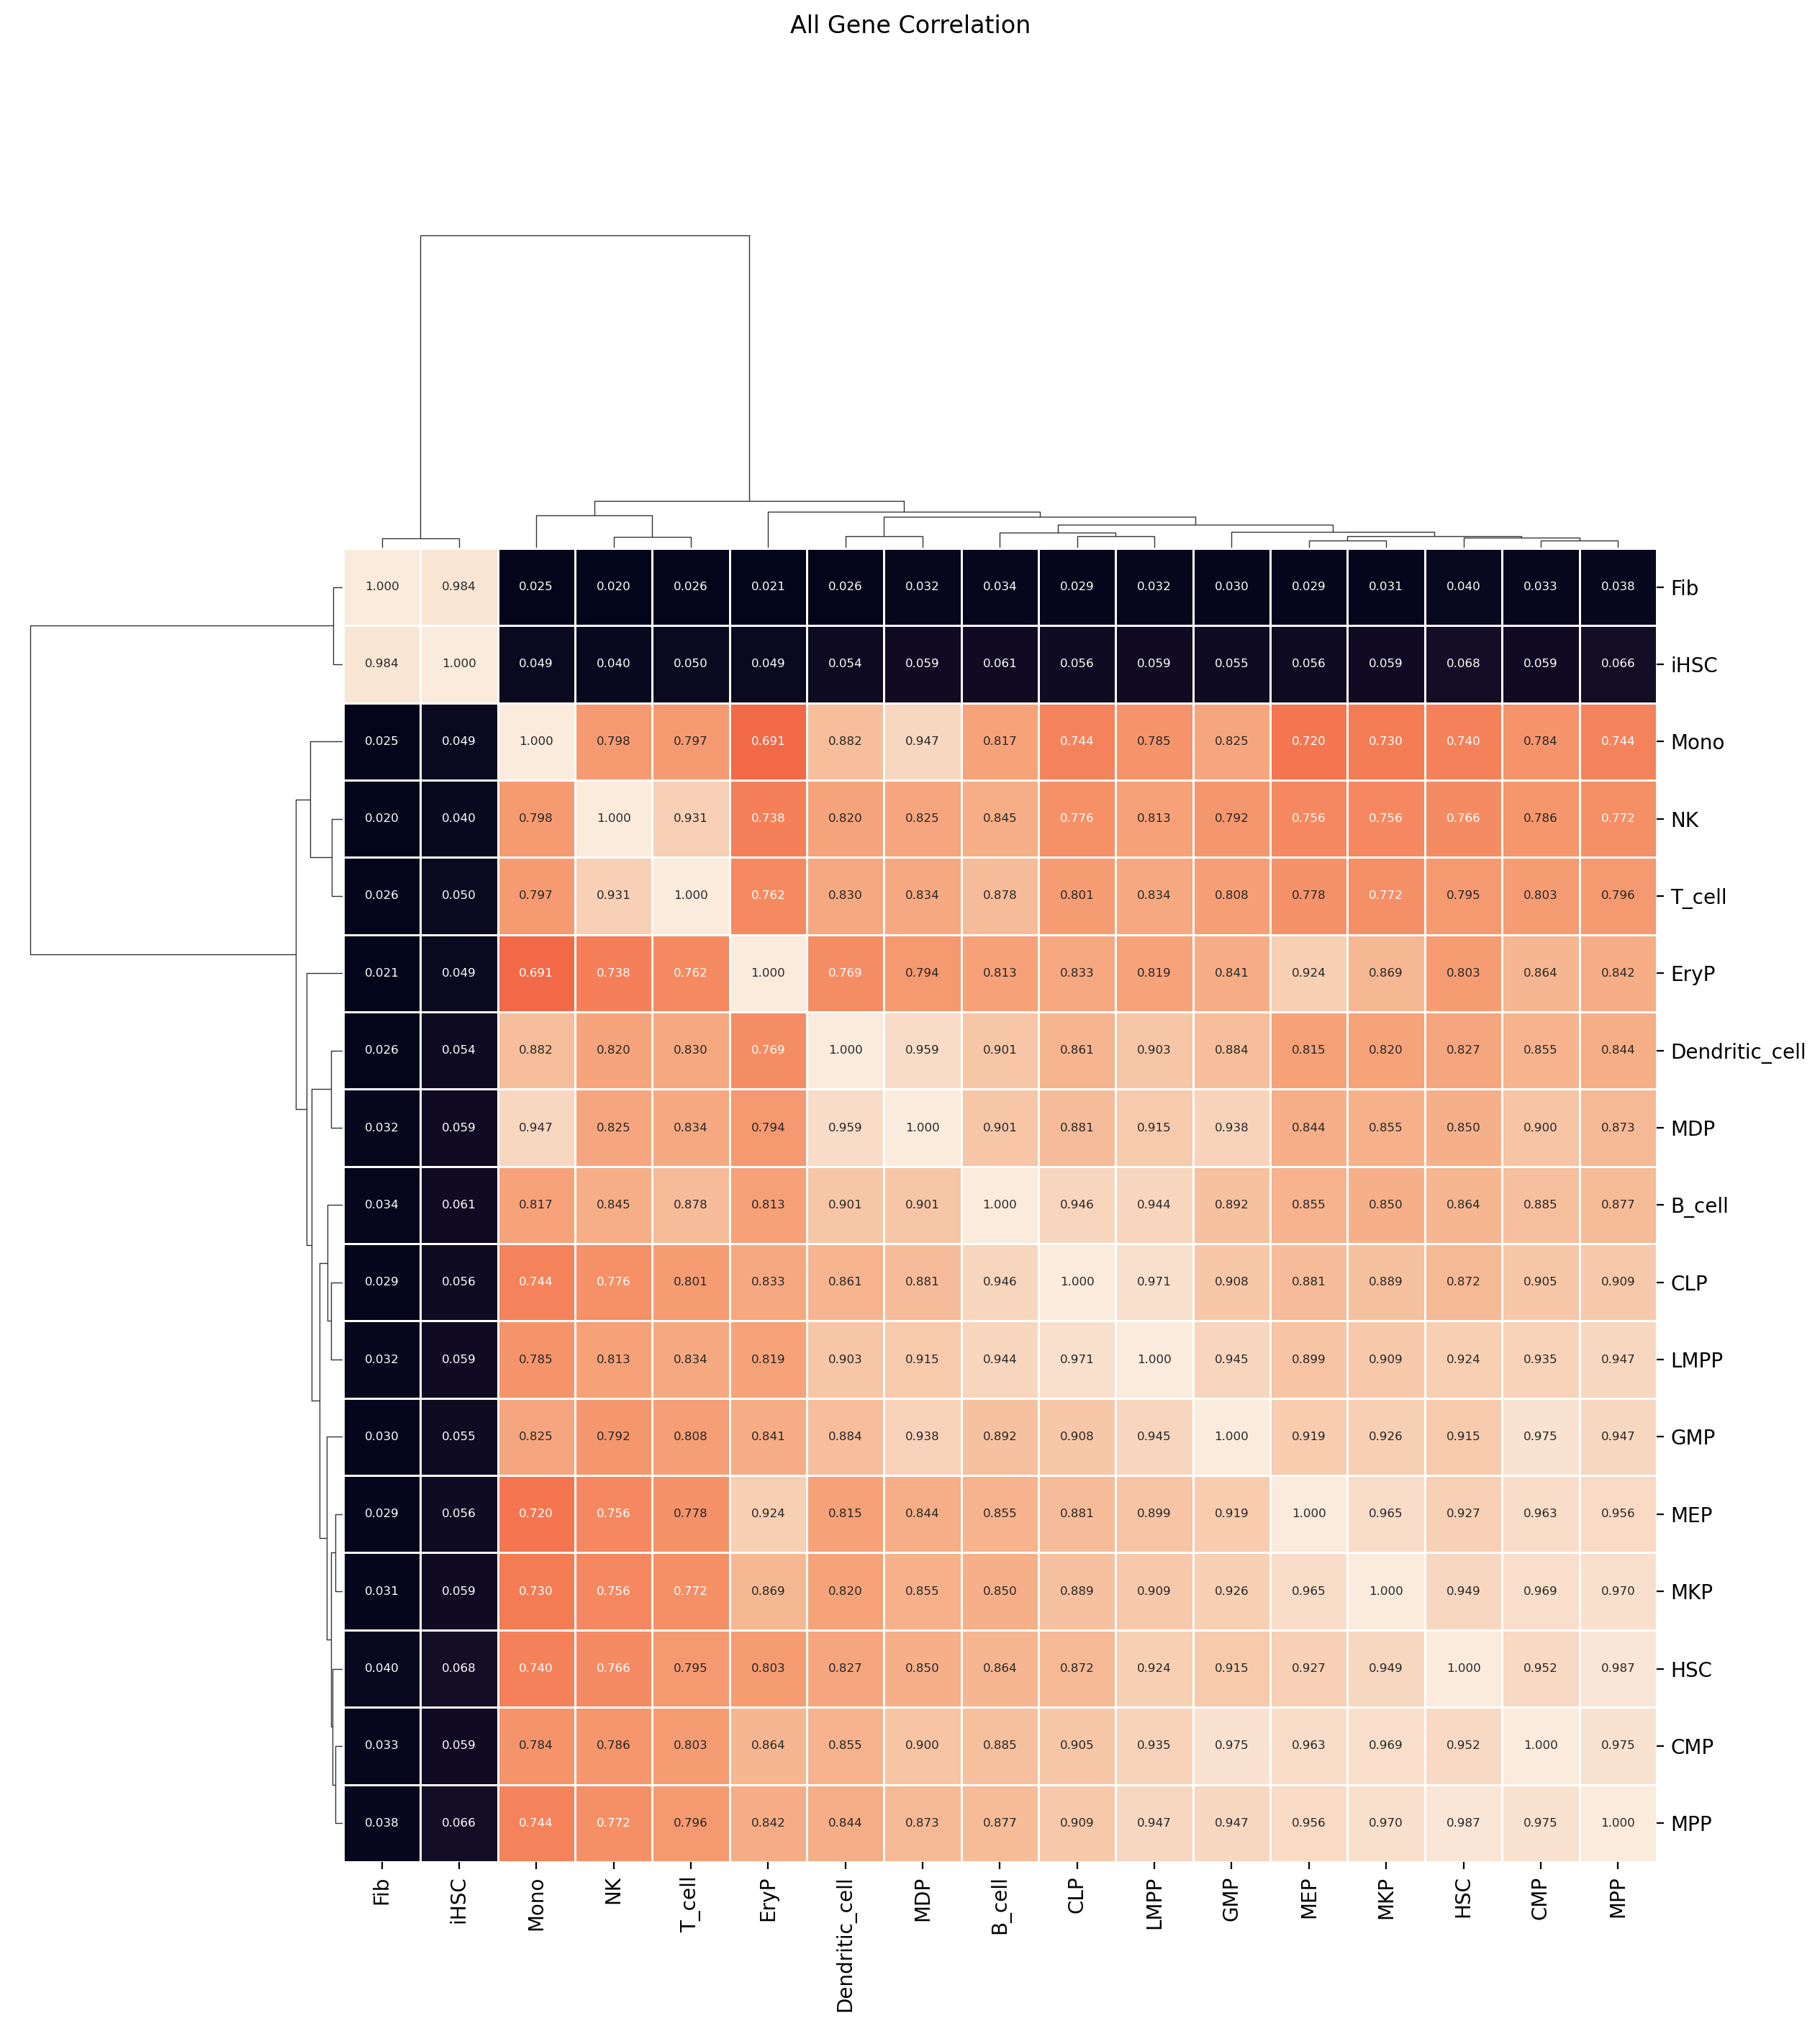

In [9]:
A = df.corr()
n = A.shape[0]
plot_n = n * 0.75

plt.rcParams['figure.dpi'] = 200

sns.clustermap(
    A, 
    square=True,
    lw=1,
    figsize=(plot_n, plot_n),
    annot=True,
    cbar_pos=None,
    fmt=".3f",
    annot_kws={'fontsize' : 6},
    cbar_kws={'shrink' : 0.45},
)
plt.suptitle('All Gene Correlation', y=1.1)

plt.gca().tick_params(axis='y', rotation=0)

# Distances

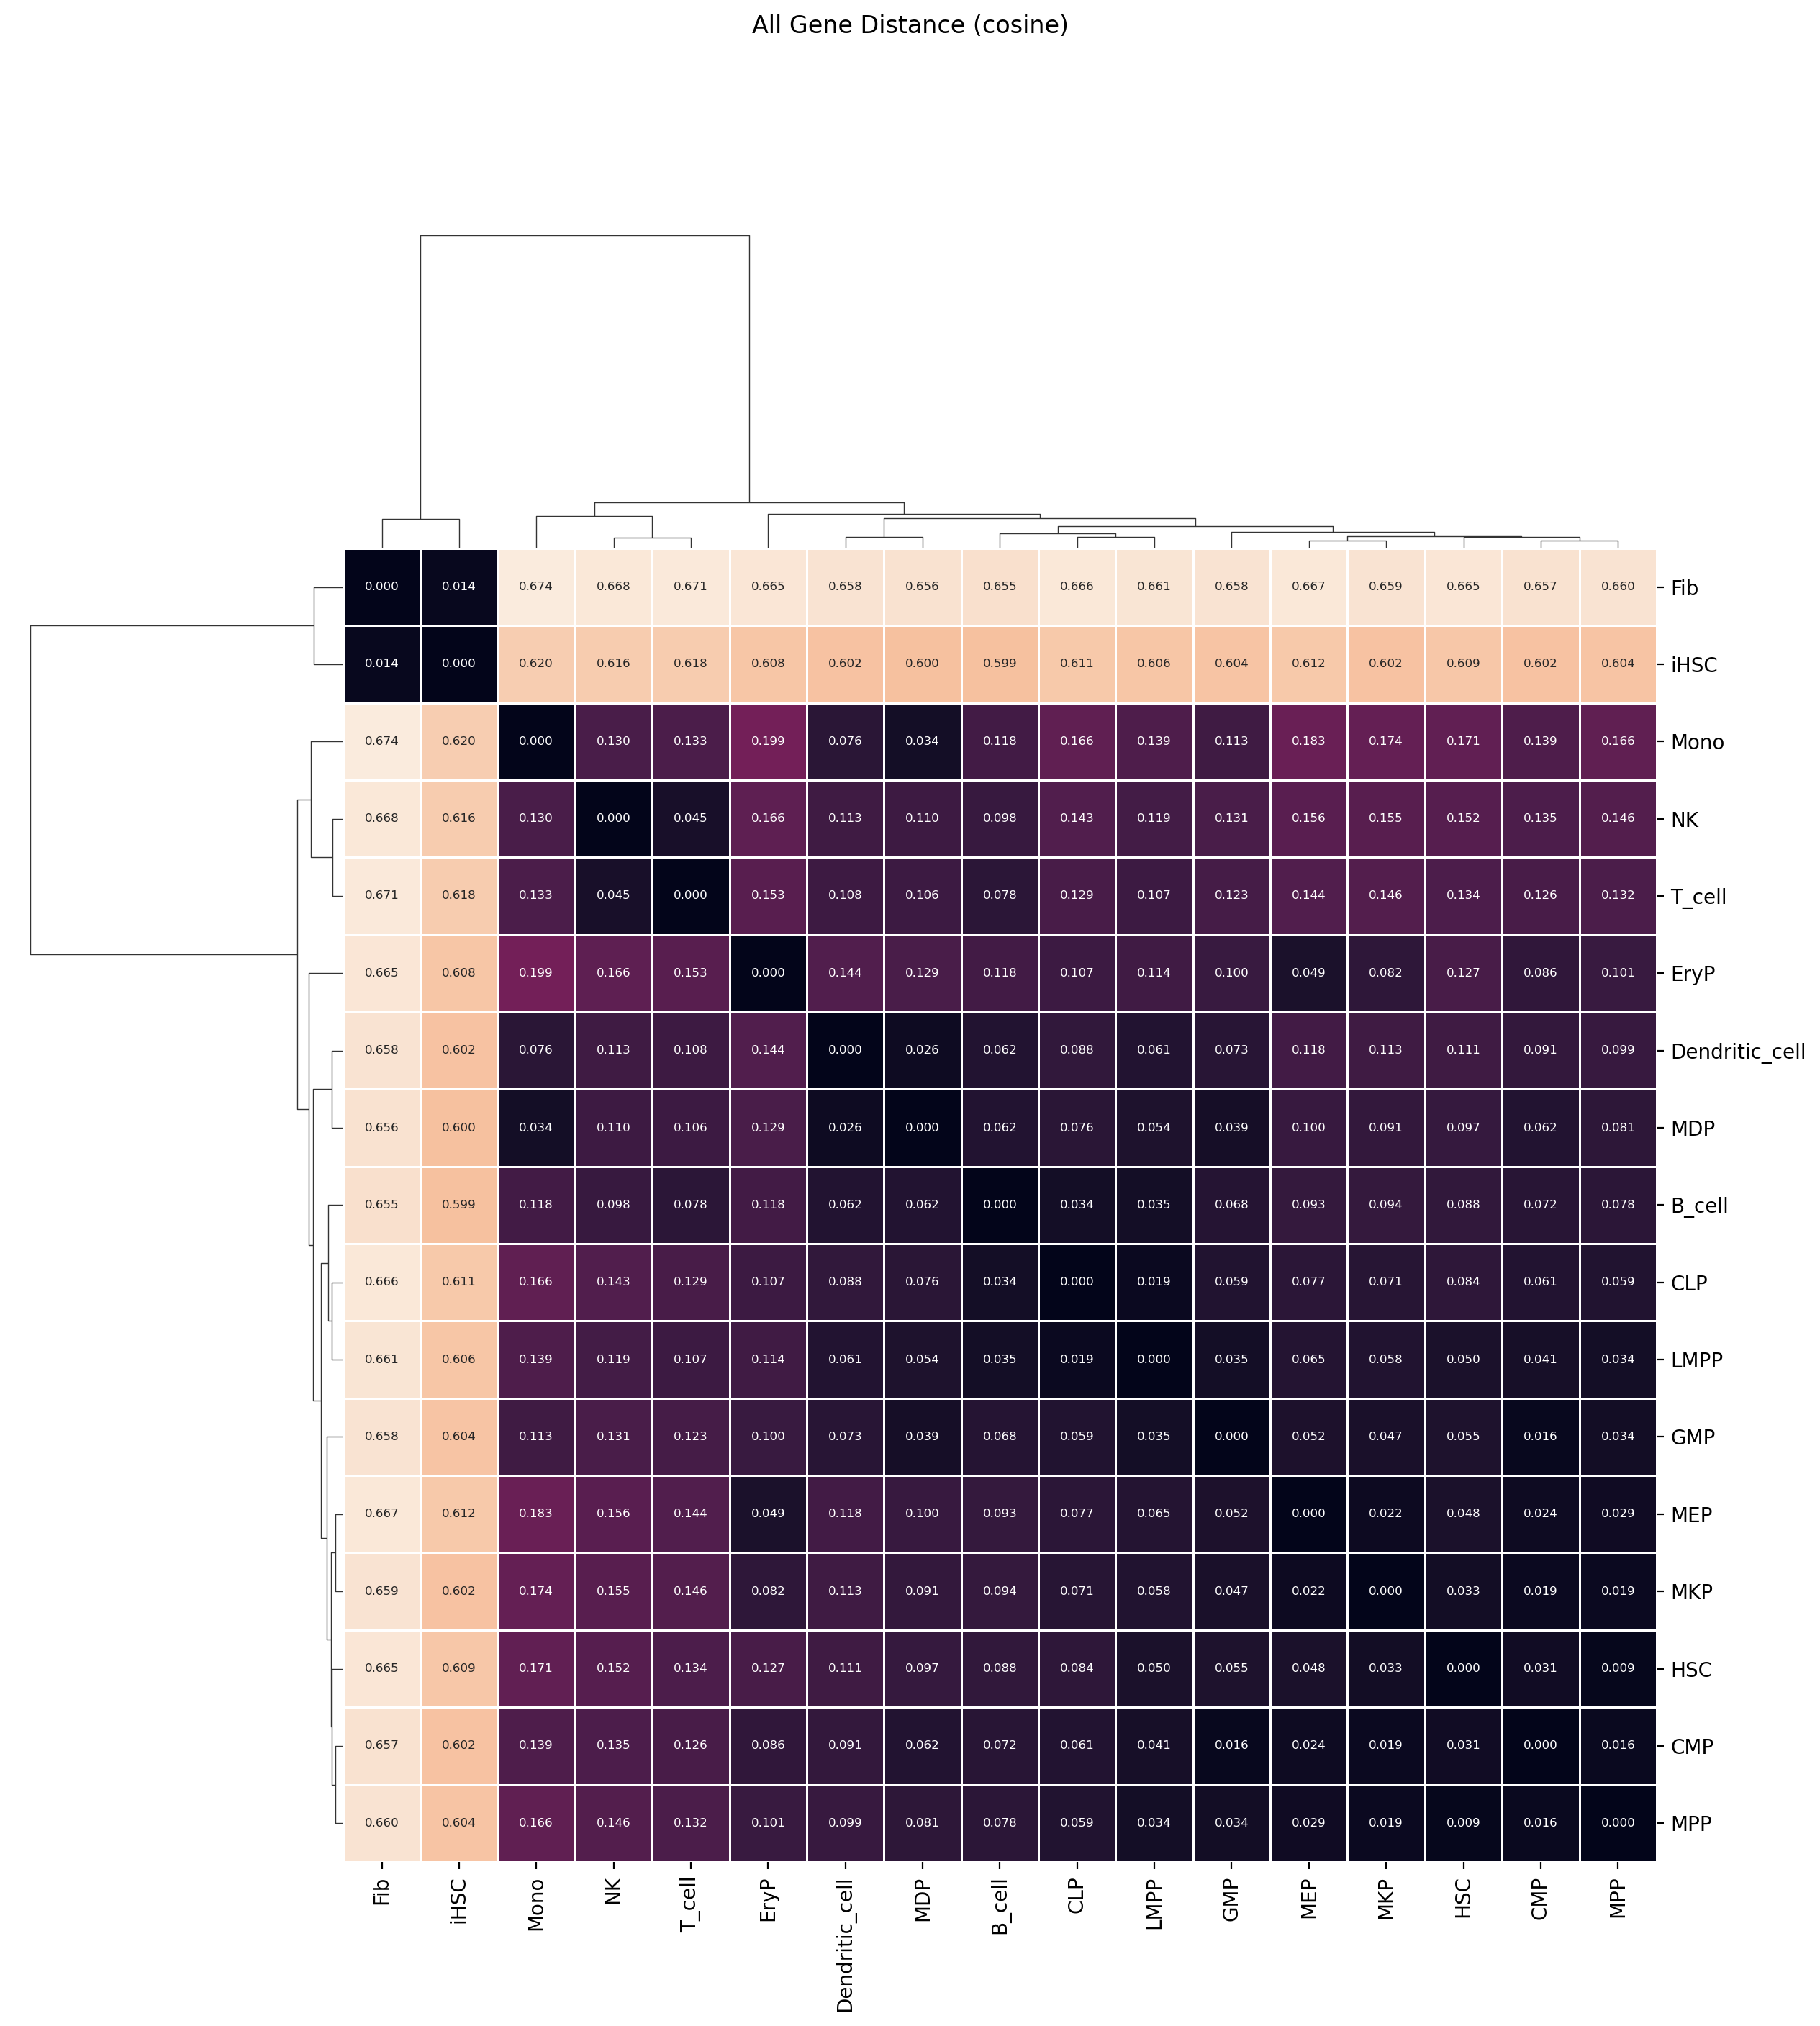

In [10]:
metric = 'cosine'
A = sm.pairwise_distances(
    df.T, 
    metric=metric,
)

# Convert to a DataFrame
A = pd.DataFrame(
    A, 
    index=df.columns,
    columns=df.columns,
)

n = A.shape[0]
plot_n = n * 0.75

plt.rcParams['figure.dpi'] = 200

sns.clustermap(
    A, 
    square=True,
    lw=1,
    figsize=(plot_n, plot_n),
    annot=True,
    cbar_pos=None,
    fmt=".3f",
    annot_kws={'fontsize' : 6},
    cbar_kws={'shrink' : 0.45},
)
plt.suptitle(f'All Gene Distance ({metric})', y=1.1)

plt.gca().tick_params(axis='y', rotation=0)

# Load annotations and filter

In [12]:
# load the obs annotations
# fpath = "/scratch/indikar_root/indikar1/shared_data/sc_HSC/obs/merged_scfib_obs.csv"
fpath = "/nfs/turbo/umms-indikar/shared/projects/HSC/pipeline_outputs/sc_HSC/obs/merged_scfib_obs.csv"
obs = pd.read_csv(fpath)

obs['new_cluster_str'] = obs['new_cluster'].apply(lambda x: f"F{int(x) + 1}")

cluster_map = dict(zip(obs['cell_id'].values, obs['cluster_str'].values))
new_cluster_map = dict(zip(obs['cell_id'].values, obs['new_cluster_str'].values))

adata.obs['cluster_str'] = adata.obs.index.map(cluster_map)
adata.obs['new_cluster_str'] = adata.obs.index.map(new_cluster_map)

# Filter cluster C6
mask = (adata.obs['cluster_str'] == 'C6') & (adata.obs['dataset'] == 'iHSC')
adata = adata[~mask, :].copy()

# filter out low-quality FB clusters
mask = (adata.obs['new_cluster_str'].isin(['F7', 'F8'])) & (adata.obs['dataset'].isin(['iHSC', 'sc_fib']))
adata = adata[~mask, :].copy()

# filter out tabula sapiens

print(adata)
print()
adata.obs['cluster_str'].value_counts()

AnnData object with n_obs × n_vars = 107375 × 11000
    obs: 'n_genes', 'dataset', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'standard_cell_type', 'cell_label', '_scvi_batch', '_scvi_labels', 'batch', 'cluster_str', 'new_cluster_str'
    uns: 'neighbors', 'pca', 'umap', 'dataset_colors', 'standard_cell_type_colors'
    obsm: 'X_harmony', 'X_pca', 'X_scanorama', 'X_scanvi', 'X_scvi', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'scanvi_counts', 'scaled_scanvi'
    obsp: 'connectivities', 'distances'



cluster_str
C1    3834
C2    1650
C3    1497
C4     558
C5      20
Name: count, dtype: int64

# annotate further

In [13]:
# sort the cells by type
sorted_indices = adata.obs['standard_cell_type'].argsort()
adata = adata[sorted_indices, :].copy() 

# establish grouping
adata.obs['group'] = np.where(adata.obs['cluster_str'].isin(['C2', 'C5']), "iHSC-high", "HSC")
adata.obs['group'] = np.where(adata.obs['cluster_str'].isin(['C1', 'C3']), "iHSC-low", adata.obs['group'])
adata.obs['group'] = np.where(adata.obs['cluster_str'] == 'C4', "BJ Fib", adata.obs['group'])
adata.obs['group'] = np.where(adata.obs['dataset'] == 'sc_fib', "BJ Fib", adata.obs['group'])

print(adata.obs['group'].value_counts())
print()

adata.obs['group2'] = adata.obs['cluster_str'].copy()
adata.obs['group2'] = np.where(adata.obs['cell_label'] == 'HSC', 'HSC', adata.obs['group2'])
adata.obs['group2'] = np.where(adata.obs['dataset'] == 'sc_fib', 'Bj Fib', adata.obs['group2'])

print(adata.obs['group2'].value_counts())
print()

group
HSC          92501
BJ Fib        7873
iHSC-low      5331
iHSC-high     1670
Name: count, dtype: int64

group2
HSC       18302
Bj Fib     7315
C1         3834
C2         1650
C3         1497
C4          558
C5           20
Name: count, dtype: int64



... storing 'cluster_str' as categorical
... storing 'new_cluster_str' as categorical
... storing 'group' as categorical
... storing 'group2' as categorical


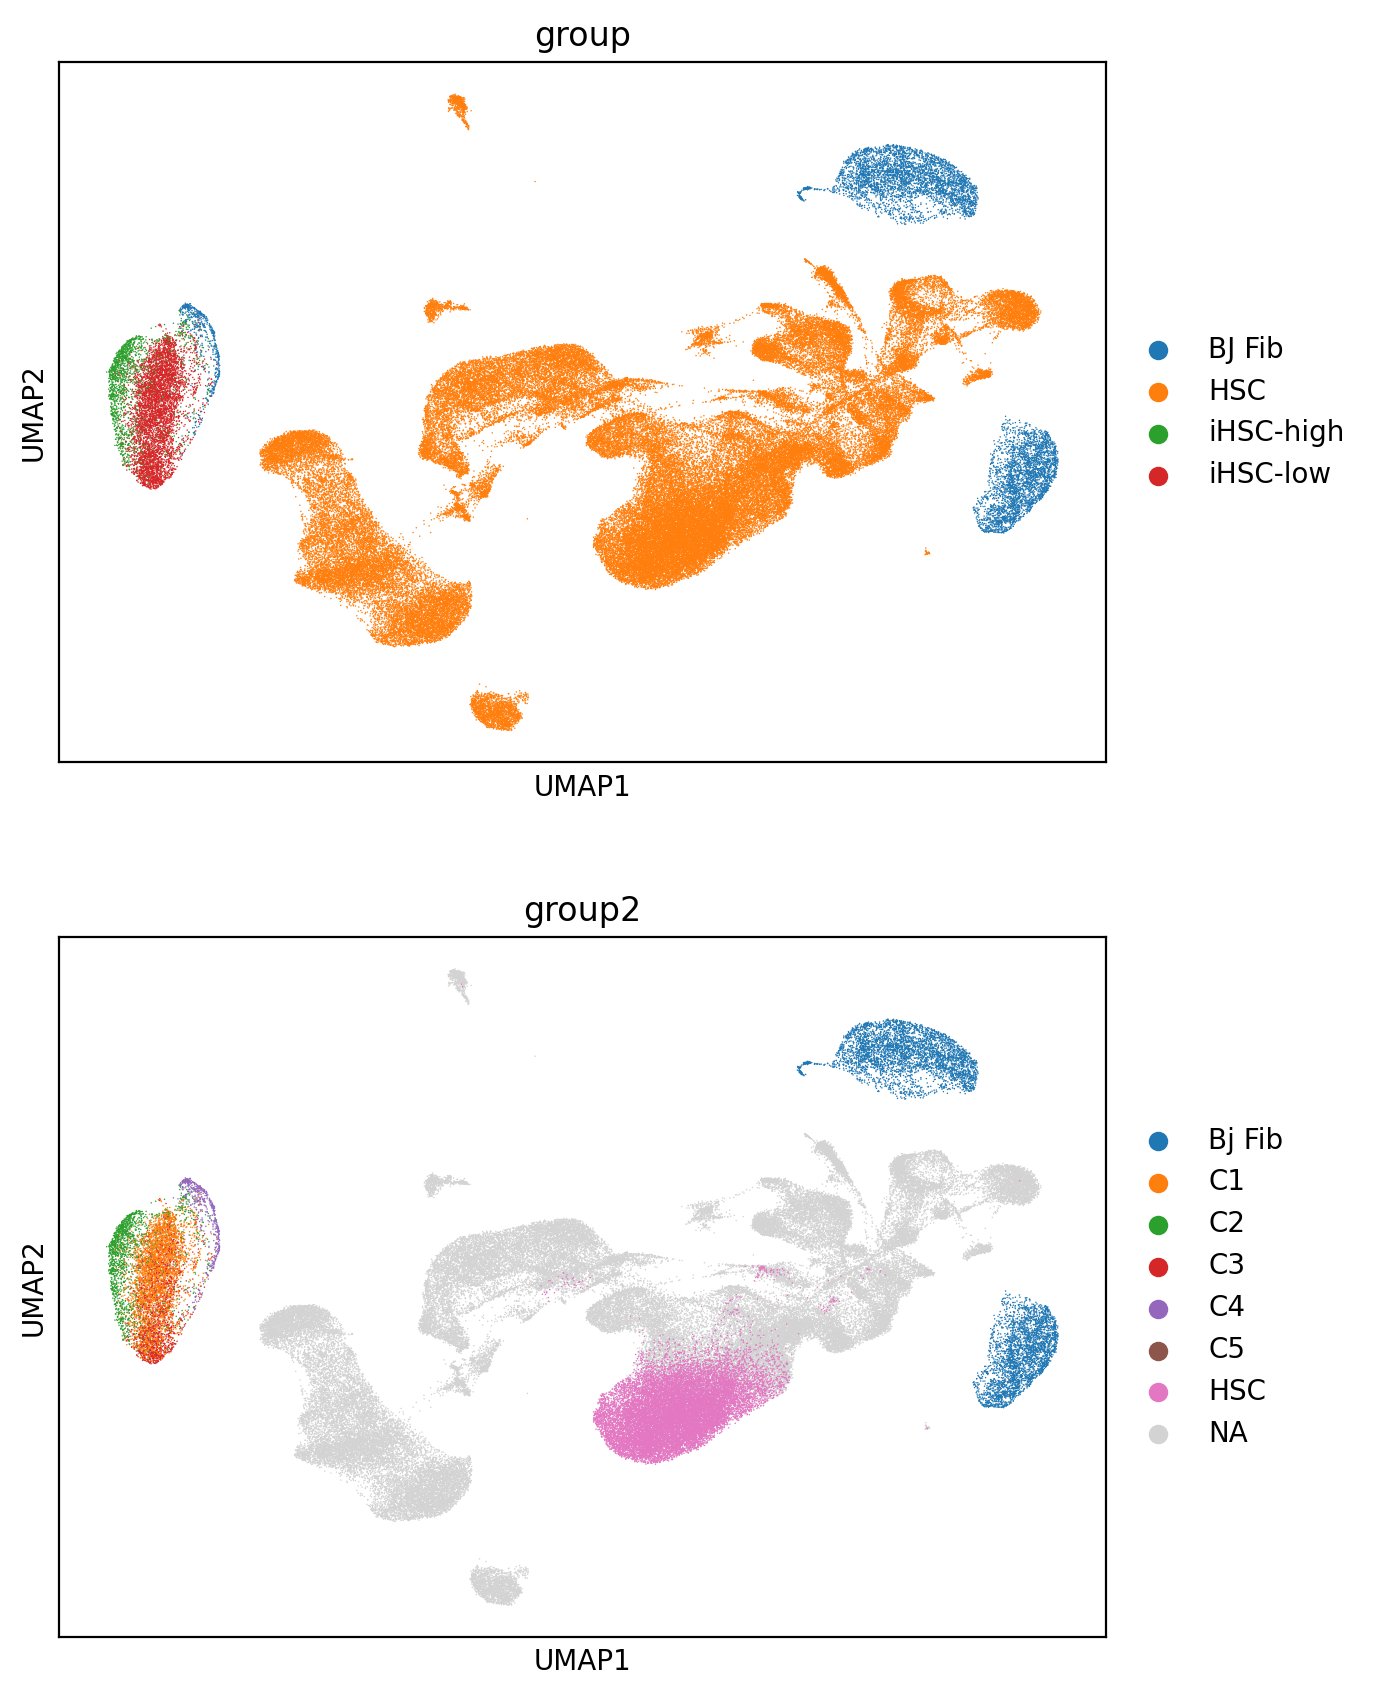

In [14]:
sc.pl.umap(
    adata,
    color=[
        'group',
        'group2',
    ],
    ncols=1,
)

# Aggregate Data

In [15]:
aggdata = sc.get.aggregate(
    adata,
    by='group',
    func='mean',
    layer='scaled_scanvi'
)

aggdata.X = aggdata.layers['mean']
df = aggdata.to_df(layer='mean')
df = df.T
df.head()

,BJ Fib,HSC,iHSC-high,iHSC-low
gene_name,,,,
A2M,0.183422,0.367753,0.302598,0.260311
A2ML1,1.469043,0.041296,0.923038,0.946056
A4GALT,0.014148,0.070017,0.040532,0.032113
AACS,0.078252,0.170815,0.121368,0.108518
AADAC,0.782654,0.015775,1.041834,0.991355


# MDS

In [16]:
d_func = scipy.spatial.distance.cosine
# d_func = scipy.spatial.distance.euclidean

comps = {
    'hsc_to_bj_fib': ('BJ Fib', 'HSC'),
    'ihsc_high_to_hsc': ('iHSC-high', 'HSC'),
    'ihsc_low_to_hsc': ('iHSC-low', 'HSC'),
    'ihsc_low_to_bj_fib': ('iHSC-low', 'BJ Fib'),
    'ihsc_high_to_bj_fib': ('iHSC-high', 'BJ Fib'),
}

for k, v in comps.items():
    distance = d_func(df[v[0]], df[v[1]])
    print(f"{k} : {distance:.3f}")

hsc_to_bj_fib : 0.643
ihsc_high_to_hsc : 0.583
ihsc_low_to_hsc : 0.593
ihsc_low_to_bj_fib : 0.014
ihsc_high_to_bj_fib : 0.018


In [18]:
def scaler(vector):
  return MinMaxScaler().fit_transform(np.array(vector).reshape(-1, 1)).flatten()

In [19]:
metric = 'cosine'
# metric = 'euclidean'

pdf = df.copy()

A = sm.pairwise_distances(
    pdf.T, 
    metric=metric,
)

# Convert to a DataFrame
A = pd.DataFrame(
    A, 
    index=pdf.columns,
    columns=pdf.columns,
)

print(A.round(3))

mds = MDS(n_components=1, dissimilarity='precomputed')
coordinates = mds.fit_transform(A)

cdf = pd.DataFrame({
    'x' : coordinates[:, 0],
    'x_scaled' : scaler(coordinates[:, 0]),
    'label' : pdf.columns,
})

cdf = cdf.sort_values("x")
cdf = cdf.reset_index(drop=True)
cdf.head()

           BJ Fib    HSC  iHSC-high  iHSC-low
BJ Fib      0.000  0.643      0.018     0.014
HSC         0.643  0.000      0.583     0.593
iHSC-high   0.018  0.583      0.000     0.001
iHSC-low    0.014  0.593      0.001     0.000


,x,x_scaled,label
0,-0.454978,0.000000,HSC
1,0.140998,0.955234,iHSC-high
2,0.145051,0.961731,iHSC-low
3,0.168928,1.000000,BJ Fib


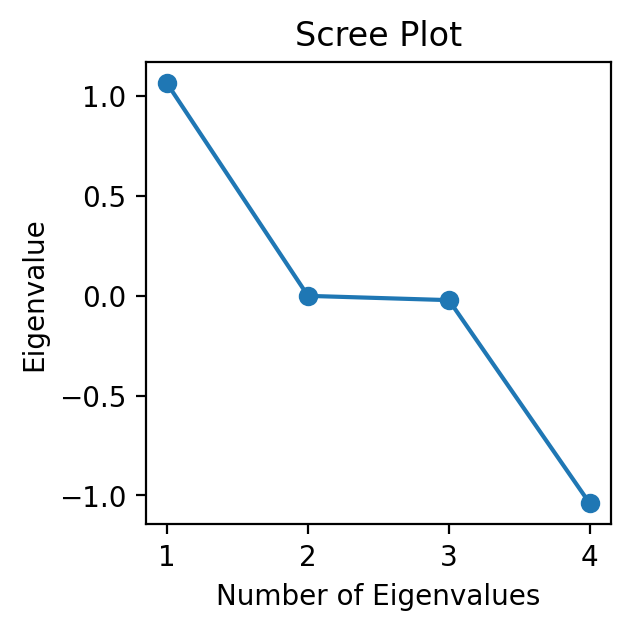

In [24]:
# 1. Convert to NumPy array
A_np = A.to_numpy()

# 2. Calculate eigenvalues (use eigh for symmetric matrices)
eigenvalues = np.linalg.eigh(A_np)[0]

# 3. Sort eigenvalues in descending order
eigenvalues = np.sort(eigenvalues)[::-1]

plt.rcParams['figure.figsize'] = 3, 3
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='-')
plt.title('Scree Plot')
plt.xlabel('Number of Eigenvalues')
plt.ylabel('Eigenvalue')
plt.show()

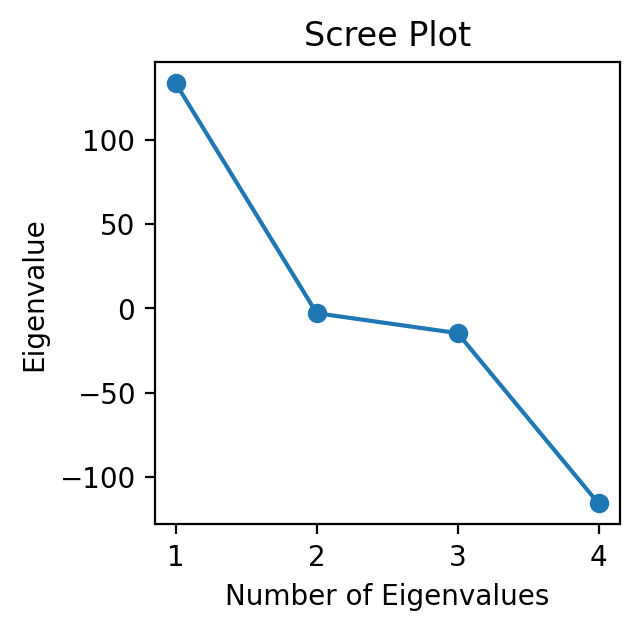

In [26]:
# metric = 'cosine'
metric = 'euclidean'

pdf = df.copy()

A = sm.pairwise_distances(
    pdf.T, 
    metric=metric,
)


# 2. Calculate eigenvalues (use eigh for symmetric matrices)
eigenvalues = np.linalg.eigh(A)[0]

# 3. Sort eigenvalues in descending order
eigenvalues = np.sort(eigenvalues)[::-1]

plt.rcParams['figure.figsize'] = 3, 3
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker='o', linestyle='-')
plt.title('Scree Plot')
plt.xlabel('Number of Eigenvalues')
plt.ylabel('Eigenvalue')
plt.show()


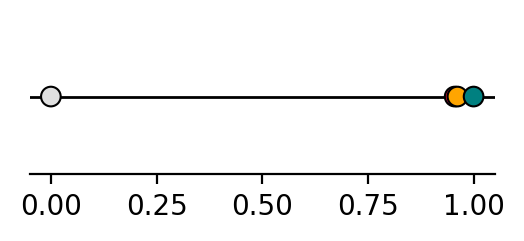

In [20]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 1

pdf = cdf.copy()

colors = [
    '#e0e0e0',    # Brighter light gray    
    '#DC143C',   # Crimson red/

    '#FFA500',    # Bright orange 
    '#008080',    # Vivid teal
    
]

sns.scatterplot(
    data=pdf,
    x='x_scaled',
    y=0.0,
    hue='label',
    marker='o',
    ec='k',
    lw=0.75,
    s=50,
    palette=colors,
    legend=False,
)

plt.axhline(y=0, zorder=0, lw=1, c='k')

sns.despine(left=True)
plt.yticks([])
plt.ylim([-0.01, 0.01])
plt.xlabel('')
plt.gcf().patch.set_facecolor('none')
plt.gca().patch.set_facecolor('none')

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 1

pdf = cdf.copy()
pdf = pdf[pdf['label'] != 'HSC']


sns.scatterplot(
    data=pdf,
    x='x_scaled',
    y=0.0,
    hue='label',
    marker='o',
    ec='k',
    lw=0.75,
    s=50,
    palette=colors,
    legend=False,
)

plt.axhline(y=0, zorder=0, lw=1, c='k')

sns.despine(left=True)
plt.yticks([])
plt.ylim([-0.01, 0.01])
plt.xlabel('reprogramming distance')
plt.gcf().patch.set_facecolor('none')
plt.gca().patch.set_facecolor('none')

In [ ]:
break

# Sample MDS

In [ ]:
adata.obs['group2'].value_counts()

In [ ]:
adata.obs['group'].value_counts()

In [ ]:
metric = 'cosine'
n = 250

# Sample n items from each group
sampled_df = adata.obs.groupby('group').apply(lambda x: x.sample(n=n, replace=False))
sampled_df = sampled_df.reset_index(level='group', drop=True)

print(sampled_df['group'].value_counts())

sample_idx = sampled_df.index
X = adata[sample_idx,].layers['scaled_scanvi']
print(f"{X.shape=}")

A = squareform(pdist(X, metric=metric))
A = pd.DataFrame(
    A,
    index=sampled_df.index,
    columns=sampled_df.index,
)

print(f"{A.shape=}")

mds = MDS(n_components=2, dissimilarity='precomputed')
coordinates = mds.fit_transform(A)
print(f"{coordinates.shape=}")

cdf = pd.DataFrame({
    'x' : coordinates[:, 0],
    'x_scaled' : scaler(coordinates[:, 0]),
    'group' : sampled_df['group'].values,
    'group2' : sampled_df['group2'].values,
})

cdf = cdf.sort_values(by='group')
cdf['group'] = cdf['group'].astype(str)
cdf = cdf[cdf['group'] != 'HSC']

cdf.head()

In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 1.25

sns.boxplot(
    data=cdf,
    x='x_scaled',
    y='group',
    hue='group',
    linecolor='k',
    width=0.4,
    hue_order=['BJ Fib', 'iHSC-low', 'iHSC-high'],
    palette=colors,
    showcaps=False,
    showfliers=False, 
)

# plt.yticks([])
plt.tick_params(axis='y', which='both', length=0) 

plt.ylabel("")
plt.xlabel("")

sns.despine(left=True)

In [ ]:
break

In [ ]:
metric = 'cosine'
n = 250

# Sample n items from each group
sampled_df = adata.obs.groupby('group').apply(lambda x: x.sample(n=n, replace=False))
sampled_df = sampled_df.reset_index(level='group', drop=True)

sample_idx = sampled_df.index
X = adata[sample_idx,].layers['scaled_scanvi']
print(f"{X.shape=}")

A = squareform(pdist(X, metric=metric))
A = pd.DataFrame(
    A,
    index=sampled_df.index,
    columns=sampled_df.index,
)

print(f"{A.shape=}")

mds = MDS(n_components=2, dissimilarity='precomputed')
coordinates = mds.fit_transform(A)
print(f"{coordinates.shape=}")

cdf = pd.DataFrame({
    'x' : coordinates[:, 0],
    'x_scaled' : scaler(coordinates[:, 0]),
    'group' : sampled_df['group'].values,
    'group2' : sampled_df['group2'].values,
})

cdf = cdf.sort_values(by='group2')
cdf['group'] = cdf['group'].astype(str)
cdf['group2'] = cdf['group2'].astype(str)
cdf = cdf[cdf['group'] != 'HSC']
cdf.head()



In [ ]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3.25, 2

sns.boxplot(
    data=cdf,
    x='x_scaled',
    y='group2',
    hue='group2',
    linecolor='k',
    width=0.45,
    palette=['lightgrey', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd'],
    showcaps=False,
    showfliers=False, 
)

# plt.yticks([])
plt.tick_params(axis='y', which='both', length=0) 

plt.ylabel("")
plt.xlabel("")

sns.despine(left=True)

In [ ]:
break

# expression and distance

In [ ]:
metric = 'cosine'
n = 500

# Sample n items from each group
sampled_df = adata.obs.groupby('group').apply(lambda x: x.sample(n=n, replace=False))
sampled_df = sampled_df.reset_index(level='group', drop=True)

sample_idx = sampled_df.index
X = adata[sample_idx,].layers['scaled_scanvi']
print(f"{X.shape=}")

A = squareform(pdist(X, metric=metric))
A = pd.DataFrame(
    A,
    index=sampled_df.index,
    columns=sampled_df.index,
)

print(f"{A.shape=}")

mds = MDS(n_components=2, dissimilarity='precomputed')
coordinates = mds.fit_transform(A)
print(f"{coordinates.shape=}")

cdf = pd.DataFrame({
    'x' : coordinates[:, 0],
    'x_scaled' : scaler(coordinates[:, 0]),
    'group' : sampled_df['group'].values,
    'group2' : sampled_df['group2'].values,
})

cdf['group'] = cdf['group'].astype(str)
cdf['group2'] = cdf['group2'].astype(str)

cdf.groupby('group')['x_scaled'].mean()

In [ ]:
result = []

exp_df = adata[sample_idx, :].to_df(layer='scaled_scanvi')
print(f"{exp_df.shape=}")

for gene in exp_df.columns:
    r, pval = scipy.stats.pearsonr(cdf['x_scaled'], exp_df[gene])
    row = df.loc[gene].to_dict()

    score = (row['iHSC-high'] - row['BJ Fib']) / (row['iHSC-high'] - row['HSC'])
    row['score'] = score
    row['gene_name'] = gene
    row['correlation'] = r
    row['p_value'] = pval
    result.append(row)

result = pd.DataFrame(result)
result = result.sort_values(by='score', ascending=False)
result.head(25)

In [ ]:
outpath = '../../../temp/mds_distance_correlation.csv'
result.to_csv(outpath, index=False)
result.head(10)

In [ ]:
reload(ut)
fpath = "../resources/PanglaoDB_Augmented_2021.txt"
features = ut.load_pathway(fpath)

pathway = 'Hematopoietic Stem Cells'
# pathway = 'Fibroblasts'
query_genes = list(features[features[pathway]].index)
query_genes = [x for x in query_genes if x in adata.var_names]

result[result['gene_name'].isin(query_genes)].sort_values(by='score', ascending=False).head(25)

In [ ]:
result.sort_values(by='score', ascending=False).head(25)

In [ ]:
break

In [ ]:
reload(ut)
fpath = "../resources/GO_Biological_Process_2023.txt"
features = ut.load_pathway(fpath)

pways = [x for x in features.columns if 'hemato' in x.lower()]
print(pways)

In [ ]:
pathway = "Hematopoietic Stem Cell Differentiation (GO:0060218)"
# pathway = "Hematopoietic Stem Cell Proliferation (GO:0071425)"
query_genes = list(features[features[pathway]].index)
query_genes = [x for x in query_genes if x in adata.var_names]
print(query_genes)

pdf = result[result['gene_name'].isin(query_genes)].copy()

pdf['BJ Fib'] =  pdf['BJ Fib'] / pdf['HSC']
pdf['iHSC-high'] =  pdf['iHSC-high'] / pdf['HSC']
pdf['iHSC-low'] =  pdf['iHSC-low'] / pdf['HSC']

pdf = pd.melt(
    pdf, 
    id_vars=['gene_name'],
    value_vars=['BJ Fib', 'iHSC-high', 'iHSC-low'],
)

pdf = pdf.sort_values(by='variable')

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 2

sns.barplot(
    data=pdf,
    x='gene_name',
    y='value',
    hue='variable',
    palette=['grey', '#d04c00', '#9309dd',],
    width=0.45,
    ec='k'
)

plt.axhline(y=1)
plt.gca().tick_params(axis='x', rotation=90)
sns.despine()


In [ ]:
break

In [ ]:
n_genes = 10
# database = 'ontology'
database = 'PanglaoDB_Augmented_2021'

pdf = result.copy()
pdf = pdf.sort_values(by='correlation', ascending=False)
edf = gget.enrichr(pdf['gene_name'].head(n_genes), database=database)

edf[['path_name', 'adj_p_val', 'overlapping_genes']].head()


In [ ]:
result = result.sort_values(by='score', ascending=False)
result.head(25)

In [ ]:
break

In [ ]:
reload(ut)
fpath = "../resources/PanglaoDB_Augmented_2021.txt"
features = ut.load_pathway(fpath)

pways = [x for x in features.columns if 'hemato' in x.lower()]
print(pways)

pathway = 'Hematopoietic Stem Cells'
# pathway = 'Fibroblasts'
query_genes = list(features[features[pathway]].index)
query_genes = [x for x in query_genes if x in adata.var_names]

result[result['gene_name'].isin(query_genes)].tail(25)

In [ ]:
result[result['gene_name'].isin(query_genes)].head(15)

In [ ]:
break

In [ ]:
metric = 'cosine'
# n = 250

# # Sample n items from each group
# sampled_df = adata.obs.groupby('group').apply(lambda x: x.sample(n=n, replace=False))
# sampled_df = sampled_df.reset_index(level='group', drop=True)

# print(sampled_df['group'].value_counts())

# sample_idx = sampled_df.index
X = adata.layers['scaled_scanvi']
print(f"{X.shape=}")

A = squareform(pdist(X, metric=metric))
A = pd.DataFrame(
    A,
    index=sampled_df.index,
    columns=sampled_df.index,
)

print(f"{A.shape=}")

# mds = MDS(n_components=2, dissimilarity='precomputed')
# coordinates = mds.fit_transform(A)
# print(f"{coordinates.shape=}")

# cdf = pd.DataFrame({
#     'x' : coordinates[:, 0],
#     'x_scaled' : scaler(coordinates[:, 0]),
#     'group' : sampled_df['group'].values,
#     'group2' : sampled_df['group2'].values,
# })

# cdf = cdf.sort_values(by='group')
# cdf['group'] = cdf['group'].astype(str)
# print(f"{cdf.shape=}")
# cdf.head()

# Archive

In [ ]:
break